# 0 - Présentation

## 🌍 Project Overview

This project leverages a Convolutional Variational Autoencoder (CVAE) to reconstruct the climatic signal, focusing on tasmax (daily maximum temperature). The goal is to quantify climatic anomalies in future scenarios based on how well the model can reproduce known climate dynamics.


## 🧠 Objective

We train the model on historical climate data from 1850 to 2000, and test its ability to reconstruct unseen data from 2000 to 2015. After that, we use the trained model to perform inference on future climate projections up to the year 2100.


## 🔍 Methodology

The model is trained to reconstruct seasonal temperature signals using past climate data.

We compute the difference between the model’s prediction and a reference climatic signal, typically from a given SSP (Shared Socioeconomic Pathway) scenario.

Large reconstruction errors indicate that the model struggles to reproduce high-frequency components — these correspond to climatic anomalies.

By analyzing these reconstruction errors, we can detect and quantify anomalies in the projected data.

## 📊 Analysis

Once the anomalies are identified, we can:

- Count their frequency and magnitude

- Track their evolution over time

- Compare different SSP scenarios based on anomaly patterns

## ❄️ Season-Specific Modeling

To capture seasonal dynamics more accurately, we chose to:

- Train a separate CVAE for each season

- Split the dataset accordingly so that each model learns from climate signals corresponding only to one season

This approach allows the models to specialize in the patterns and variabilities unique to each time of year.

# 1 - Import des modules

Pip install the  clemoule/xtclim@notebook_integration version of ITWINAI.

XTCLIM is a plugin of ITWINAI

In [22]:
!pip uninstall --yes itwinai-xtclim-plugin
!pip install --no-cache-dir git+https://github.com/clemoule/xtclim@notebook_integration
!pip install itwinai

Found existing installation: itwinai-xtclim-plugin 0.1.0
Uninstalling itwinai-xtclim-plugin-0.1.0:
  Successfully uninstalled itwinai-xtclim-plugin-0.1.0
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/clemoule/xtclim (to revision notebook_integration) to /tmp/pip-req-build-0sgtqiu2
  Running command git clone --filter=blob:none --quiet https://github.com/clemoule/xtclim /tmp/pip-req-build-0sgtqiu2
  Running command git checkout -b notebook_integration --track origin/notebook_integration
  Switched to a new branch 'notebook_integration'
  Branch 'notebook_integration' set up to track remote branch 'notebook_integration' from 'origin'.
  Resolved https://github.com/clemoule/xtclim to commit 9f04d5f745ba68fc9ef83ea05cb19ba908acd52c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for itwinai-xtclim-plugin: filename=itwinai_xtclim

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml

# 2 - Configuration

All the relevant parameters are parsed through a config.yaml file. The file is structured as such :

- GENERAL: defines paths and objects of study

- TRAIN: defines training parameters

- MODEL: defines model parameters and the anomaly threshold

- training_pipeline: uses all the aforementioned parameters

If you want to customize the config file, you might want to pay attention to :

- Choose which scenario and which seasons you want to study (seasons, scenarios)

- Choose the historical data you want to to use to train the models (histo_extr)

- Choose the projection data you want to study for each scenario (scenario_extr)

- Choose a zone to study (Geographical region bounding box). Must be 32x32 domain. Autopad is to come soon.

- Set the training parameters (TRAIN)

- Set the model parameters (MODEL)

# 3 - Pipeline

In [24]:
%env HYDRA_FULL_ERROR=1
%env NUMEXPR_MAX_THREADS=256

env: HYDRA_FULL_ERROR=1
env: NUMEXPR_MAX_THREADS=256


## 3.1 - Preprocessing

Data normalization, 
xarray conversion

Splits a data set into train and test data (and time)

In [25]:
!itwinai exec-pipeline \
  --config-name=config.yaml \
  +pipe_steps=["preprocessing-step"]

Successfully selected steps ['preprocessing-step']
#######################################
# Starting execution of 'Pipeline'... #
#######################################
#############################################
# Starting execution of 'PreprocessData'... #
#############################################
tasmax_day_CMCC-ESM2_historical_r1i1p1f1_gn_19500101-19741231.nc
tasmax_day_CMCC-ESM2_historical_r1i1p1f1_gn_19750101-19991231.nc
tasmax_day_CMCC-ESM2_historical_r1i1p1f1_gn_20000101-20141231.nc


## 3.2 - Preprocessing-split

Splits and returns the data sets (climate variable and time) per season.

In [15]:
!itwinai exec-pipeline \
  --config-name=config.yaml \
  +pipe_steps=["preprocessing-split-step"]

Successfully selected steps ['preprocessing-split-step']
#######################################
# Starting execution of 'Pipeline'... #
#######################################
####################################################
# Starting execution of 'SplitPreprocessedData'... #
####################################################
##############################################
# 'SplitPreprocessedData' executed in 2.110s #
##############################################
#################################
# 'Pipeline' executed in 2.110s #
#################################


## 3.3 - Training

Fit a model using historical data (1 model per season)

In [4]:
!itwinai exec-pipeline \
  --config-name=config.yaml \
  +pipe_steps=["training-step"]

Successfully selected steps ['training-step']
#######################################
# Starting execution of 'Pipeline'... #
#######################################
###########################################
# Starting execution of 'TorchTrainer'... #
###########################################
Training season: winter
Epoch 1/100
100%|████████████████████████████████████████| 117/117 [00:00<00:00, 889.86it/s]
Figure(1000x700)
Epoch 2/100
100%|████████████████████████████████████████| 117/117 [00:00<00:00, 894.39it/s]
Figure(1000x700)
Epoch 3/100
100%|████████████████████████████████████████| 117/117 [00:00<00:00, 881.15it/s]
Figure(1000x700)
Epoch 4/100
100%|████████████████████████████████████████| 117/117 [00:00<00:00, 876.05it/s]
Epoch 5/100
100%|████████████████████████████████████████| 117/117 [00:00<00:00, 876.92it/s]
Epoch 6/100
100%|████████████████████████████████████████| 117/117 [00:00<00:00, 894.67it/s]
Figure(1000x700)
Epoch 7/100
100%|███████████████████████████████████

## 3.4 - Inference

Predict the behaviour of each scenario or predict the behaviour of the train and test set

### 3.4.1 - Train and test inference

In [9]:
!itwinai exec-pipeline \
  --config-name=config.yaml \
  GENERAL.on_train_test=True \
  +pipe_steps=["inference-step"]

Successfully selected steps ['inference-step']
#######################################
# Starting execution of 'Pipeline'... #
#######################################
#############################################
# Starting execution of 'TorchInference'... #
#############################################
Running inference for season: winter
/ceph/hpc/home/ciangottinid/.local/lib/python3.10/site-packages/itwinai/plugins/xtclim/src/trainer.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be lo

### 3.4.1 - Projection inference

In [10]:
!itwinai exec-pipeline \
  --config-name=config.yaml \
  GENERAL.on_train_test=False \
  +pipe_steps=["inference-step"]

Successfully selected steps ['inference-step']
#######################################
# Starting execution of 'Pipeline'... #
#######################################
#############################################
# Starting execution of 'TorchInference'... #
#############################################
Running inference for season: winter
/ceph/hpc/home/ciangottinid/.local/lib/python3.10/site-packages/itwinai/plugins/xtclim/src/trainer.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be lo

# 4 - Results analysis

In [4]:
# set up some variables
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

scenarios = config["GENERAL"]["scenarios"]
columns = ["train", "test"] + [f"ssp{ssp}" for ssp in scenarios]
seasons = config["GENERAL"]["seasons"]
season_sizes = {"winter": 90, "spring": 91, "summer": 92, "autumn": 92, "": 365}
total_days_per_year = season_sizes[""]
anomaly_percent = config["MODEL"]["anomaly_percent"]

In [5]:
# Lecture des fichiers
for season in seasons:
    # train time per day (for each season)
    globals()[f"train_time_{season}"] = pd.read_csv(f"./inputs/dates_train_{season}_data_1memb.csv")
    # test time per day (for each season)
    globals()[f"test_time_{season}"] = pd.read_csv(f"./inputs/dates_test_{season}_data_1memb.csv")
    # proj time per day (for each season)
    globals()[f"proj_time_{season}"] = pd.read_csv(f"./inputs/dates_proj_{season}_data_1memb.csv")
    # train loss per epoch (for each season)
    globals()[f"train_loss_per_epoch_{season}"] = pd.read_csv(f"./outputs/train_loss_per_epoch_indiv_{season}_1d_1memb.csv")
    # test loss per epoch (for each season)
    globals()[f"test_loss_per_epoch_{season}"] = pd.read_csv(f"./outputs/test_loss_per_epoch_indiv_{season}_1d_1memb.csv")
    # train loss per day (for each season)
    globals()[f"train_loss_{season}"] = pd.read_csv(f"./outputs/train_loss_indiv_{season}_1d_1memb.csv")
    # test loss per day (for each season)
    globals()[f"test_loss_{season}"] = pd.read_csv(f"./outputs/test_loss_indiv_{season}_1d_1memb.csv")
    print(f"train_time_{season}")
    print(f"test_time_{season}")
    print(f"proj_time_{season}")
    print(f"train_loss_{season}")
    print(f"test_loss_{season}")
    print(f"train_loss_per_epoch_{season}")
    print(f"test_loss_per_epoch_{season}")
    for scenario in scenarios:
        # proj loss per day (for each season)
        globals()[f"proj_loss_{season}_{scenario}"] = pd.read_csv(f"./outputs/proj{scenario}_loss_indiv_{season}_1d_1memb.csv")
        print(f"proj_loss_{season}_{scenario}")

train_time_winter
test_time_winter
proj_time_winter
train_loss_winter
test_loss_winter
train_loss_per_epoch_winter
test_loss_per_epoch_winter
proj_loss_winter_585
proj_loss_winter_245
train_time_spring
test_time_spring
proj_time_spring
train_loss_spring
test_loss_spring
train_loss_per_epoch_spring
test_loss_per_epoch_spring
proj_loss_spring_585
proj_loss_spring_245
train_time_summer
test_time_summer
proj_time_summer
train_loss_summer
test_loss_summer
train_loss_per_epoch_summer
test_loss_per_epoch_summer
proj_loss_summer_585
proj_loss_summer_245
train_time_autumn
test_time_autumn
proj_time_autumn
train_loss_autumn
test_loss_autumn
train_loss_per_epoch_autumn
test_loss_per_epoch_autumn
proj_loss_autumn_585
proj_loss_autumn_245


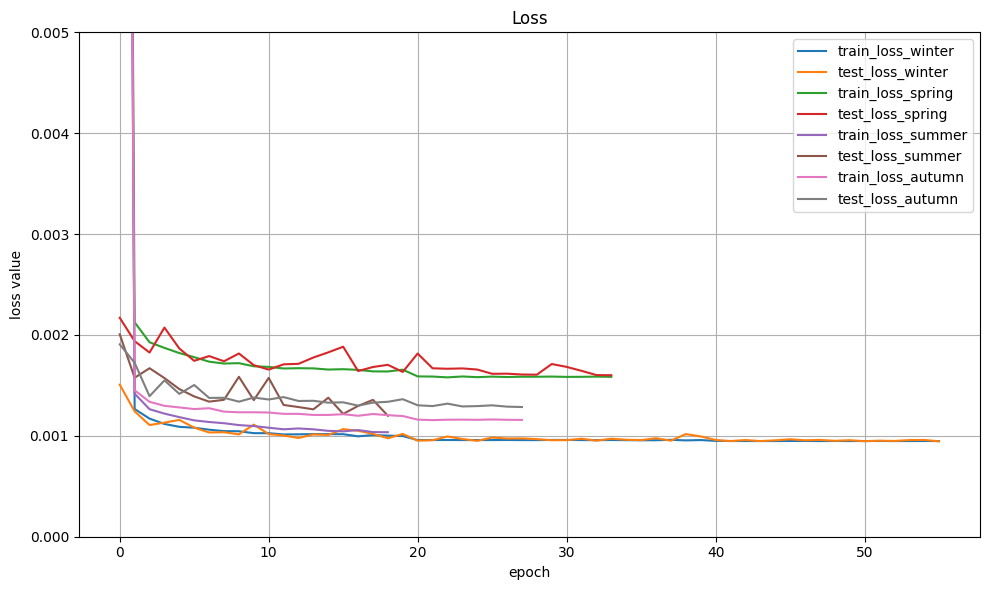

In [16]:
def display_fit():
    plt.figure(figsize=(10, 6))  # Optionnel, pour une meilleure taille de figure

    for season in seasons:
        train_loss = globals()[f"train_loss_per_epoch_{season}"]
        test_loss = globals()[f"test_loss_per_epoch_{season}"]

        sns.lineplot(x=train_loss.index, y=train_loss.iloc[:, 0], label=f"train_loss_{season}")
        sns.lineplot(x=test_loss.index, y=test_loss.iloc[:, 0], label=f"test_loss_{season}")

    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss value")
    plt.ylim(0, 0.005)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


display_fit()

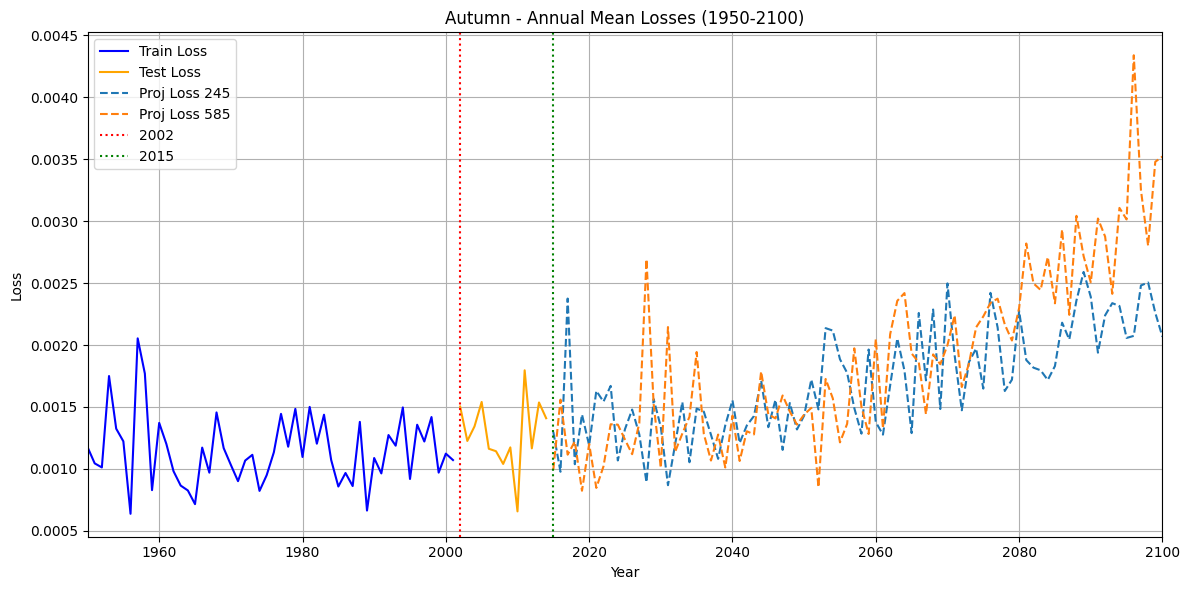

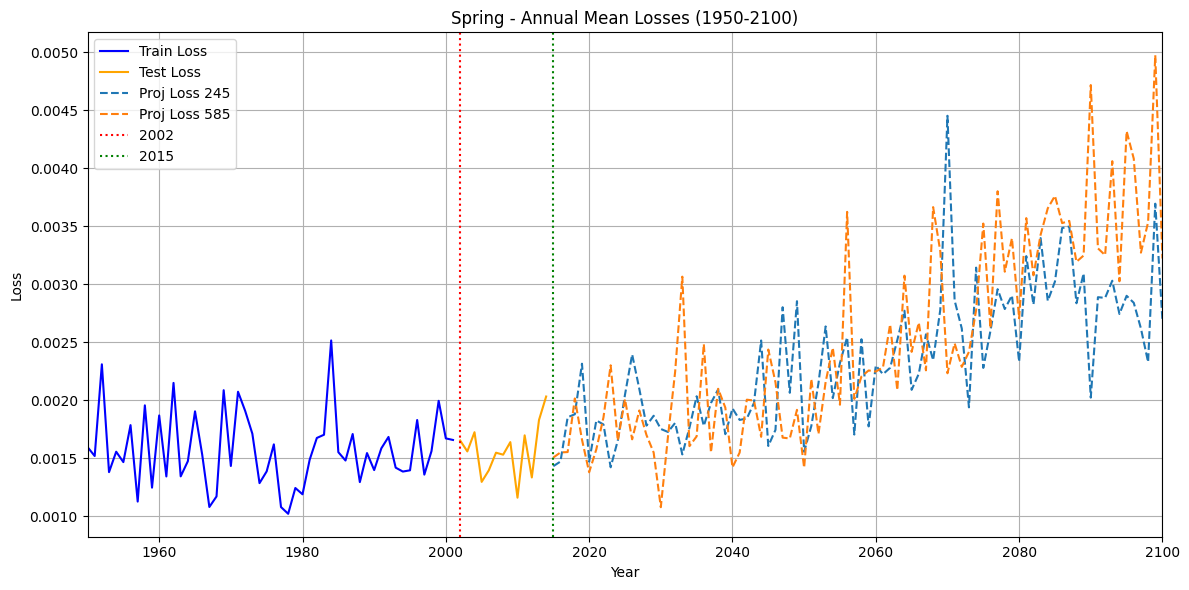

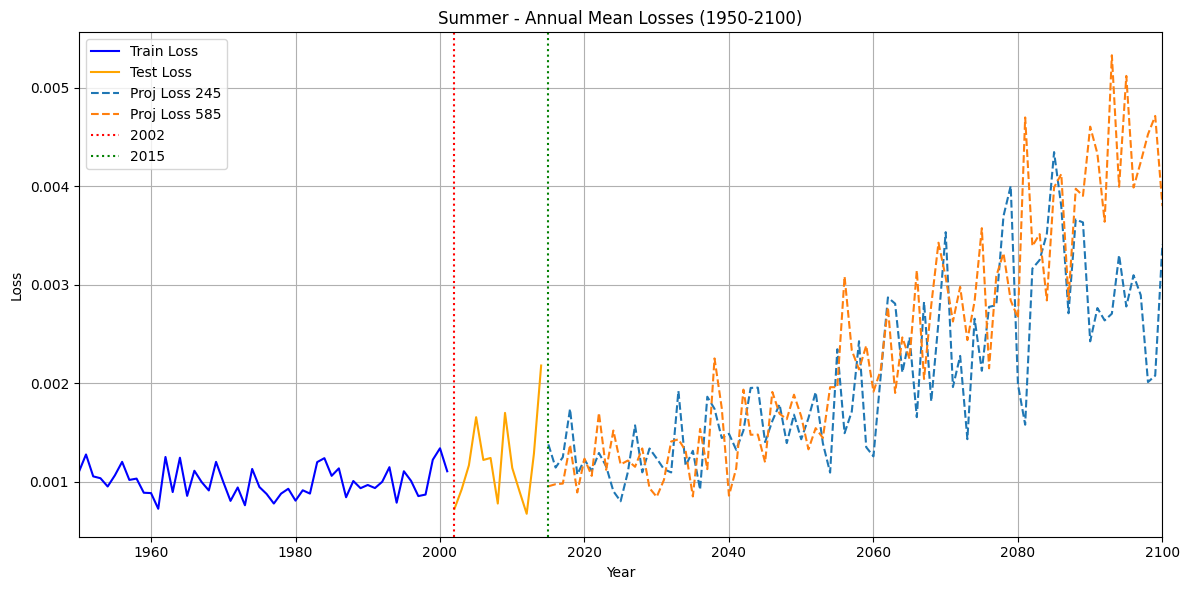

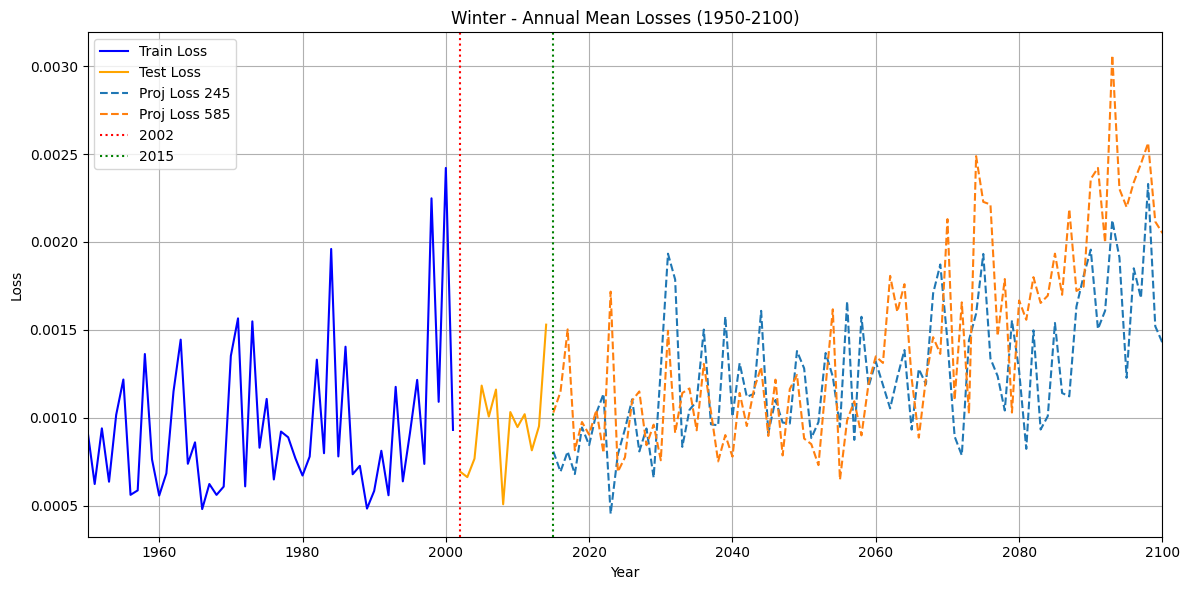

In [ ]:
import pandas as pd


def plot_losses(season: str, average: str = "year", percentile: int = 99):
    """
    Trace train, test, and projection losses for a given season on a single plot,
    with vertical lines at 2002 and 2014.

    Parameters:
    - season: 'winter', 'spring', 'summer', or 'autumn'.
    - average: 'year' or 'season', to plot yearly or seasonal means.
    """
    # Load data dynamically from CSV files
    train_time = pd.read_csv(f"./inputs/dates_train_{season}_data_1memb.csv")
    train_loss = pd.read_csv(f"./outputs/train_loss_indiv_{season}_1d_1memb.csv")
    test_time = pd.read_csv(f"./inputs/dates_test_{season}_data_1memb.csv")
    test_loss = pd.read_csv(f"./outputs/test_loss_indiv_{season}_1d_1memb.csv")
    proj_time = pd.read_csv(f"./inputs/dates_proj_{season}_data_1memb.csv")
    proj_losses = {
        "245": pd.read_csv(f"./outputs/proj245_loss_indiv_{season}_1d_1memb.csv"),
        "585": pd.read_csv(f"./outputs/proj585_loss_indiv_{season}_1d_1memb.csv"),
    }

    # Helper: build a series
    def make_series(time_df, loss_df):
        ts = pd.to_datetime(time_df.iloc[:, 1])
        ls = loss_df.iloc[:, 1].astype(float)
        return pd.Series(data=ls.values, index=ts, name="loss")

    s_train = make_series(train_time, train_loss)
    s_test = make_series(test_time, test_loss)
    s_proj = {label: make_series(proj_time, df) for label, df in proj_losses.items()}

    # Optionally group
    def group_series(s: pd.Series):
        if average == "year":
            return s.resample("YE").mean().rename(s.name)
        elif average == "season":
            # Define meteorological seasons
            seasons = (s.index.month % 12 + 3) // 3
            df = pd.DataFrame({"loss": s.values, "year": s.index.year, "season": seasons})
            df.loc[(df["season"] == 1) & (s.index.month == 12), "year"] += 1
            grouped = df.groupby(["year", "season"])["loss"].mean()
            season_month_day = {1: "-02-15", 2: "-05-15", 3: "-08-15", 4: "-11-15"}
            season_month_day = {1: "-01-01", 2: "-04-01", 3: "-07-01", 4: "-10-01"}  # test
            dates = grouped.index.to_frame()
            dates["date"] = pd.to_datetime(dates["year"].astype(str) + dates["season"].map(season_month_day))
            grouped.index = dates["date"]
            return grouped.rename(s.name)
        else:
            raise ValueError("average must be 'year' or 'season'")

    # Group if needed
    if average in ["year", "season"]:
        s_train_g = group_series(s_train)
        s_test_g = group_series(s_test)
        s_proj_g = {label: group_series(s) for label, s in s_proj.items()}
    else:
        s_train_g, s_test_g, s_proj_g = s_train, s_test, s_proj

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(s_train_g.index.year if average == "year" else s_train_g.index, s_train_g.values, label="Train Loss", color="blue")
    plt.plot(s_test_g.index.year if average == "year" else s_test_g.index, s_test_g.values, label="Test Loss", color="orange")
    for label, series in s_proj_g.items():
        plt.plot(
            series.index.year if average == "year" else series.index, series.values, label=f"Proj Loss {label}", linestyle="--"
        )

    plt.axvline(x=2002, color="red", linestyle=":", label="2002")
    plt.axvline(x=2015, color="green", linestyle=":", label="2015")
    plt.xlim(1950, 2100)
    plt.ylim(0, 0.006)
    plt.xlabel("Year")
    plt.ylabel("Loss")
    plt.title(f"{season.capitalize()} - {'Annual' if average == 'year' else 'Seasonal'} Mean Losses (1950-2100)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"./figs/{season}_mean_losses.png")  # ou .jpg, .pdf, etc.
    plt.show()


# Exemple d'appel :
plot_losses("autumn", average="year")
plot_losses("spring", average="year")
plot_losses("summer", average="year")
plot_losses("winter", average="year")

In [ ]:
def detect_anomalies_on_window(values, threshold, window_size):
    """
    Pour chaque intervalle de `window_size` jours consécutifs,
    retourne le nombre d'anomalies (valeurs > seuil) et l'intervalle.

    Args:
        values (np.array or list): série de valeurs (ex: pertes projetées)
        threshold (float): valeur seuil à dépasser pour qu'une valeur soit une anomalie
        window_size (int): nombre de jours consécutifs à analyser

    Returns:
        List[Tuple[int, int, int]]: liste de (jour_debut, jour_fin, nb_anomalies)
    """
    results = []
    for i in range(len(values) - window_size + 1):
        window = values[i : i + window_size]
        anomaly_count = (window > threshold).sum()
        results.append((i, i + window_size - 1, anomaly_count))
    return results

Season winter - Scenario ssp585: 200 days above threshold 0.0047


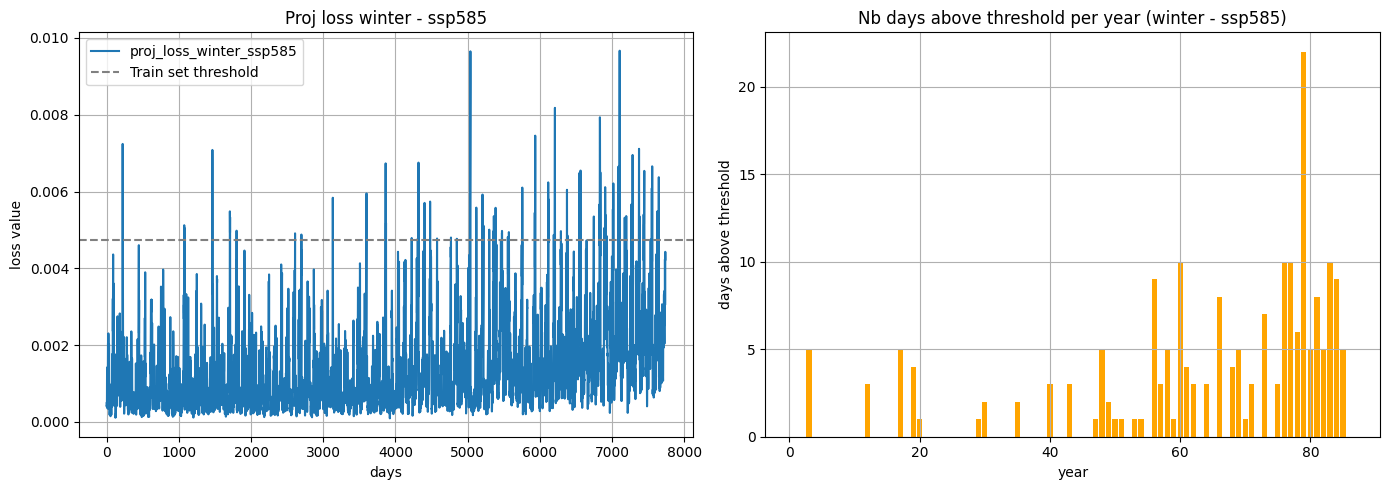

Season winter - Scenario ssp245: 158 days above threshold 0.0047


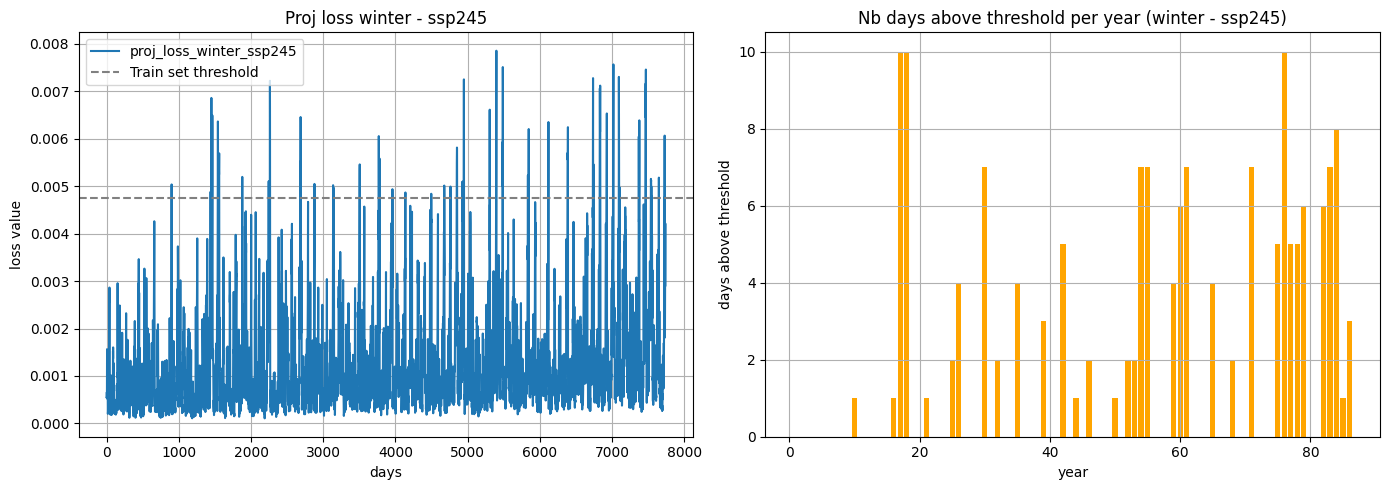

Season spring - Scenario ssp585: 879 days above threshold 0.0055


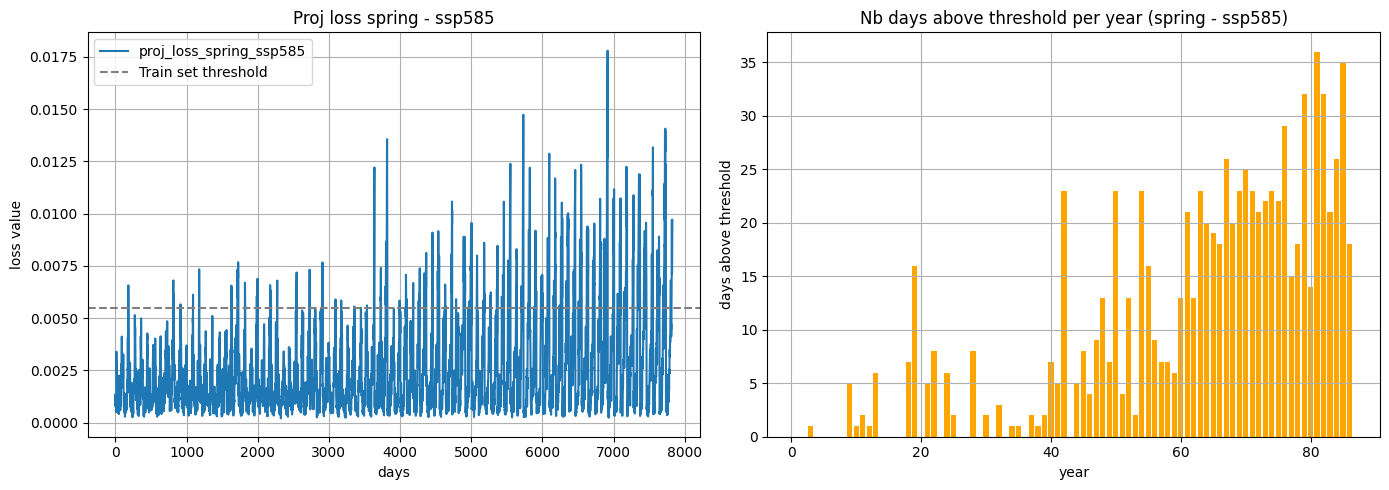

Season spring - Scenario ssp245: 687 days above threshold 0.0055


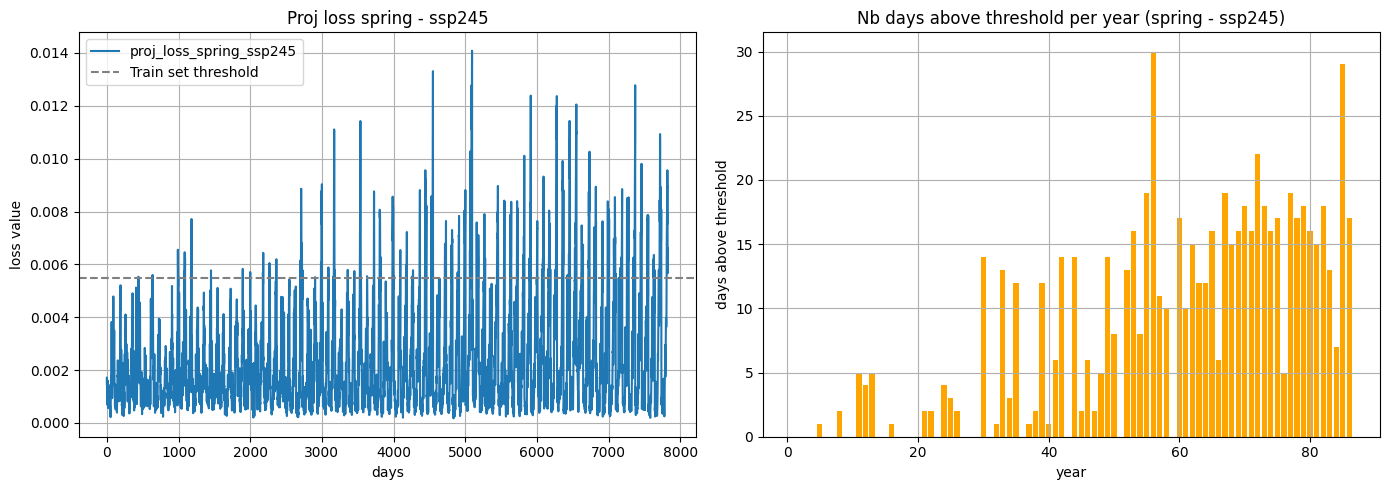

Season summer - Scenario ssp585: 1673 days above threshold 0.0037


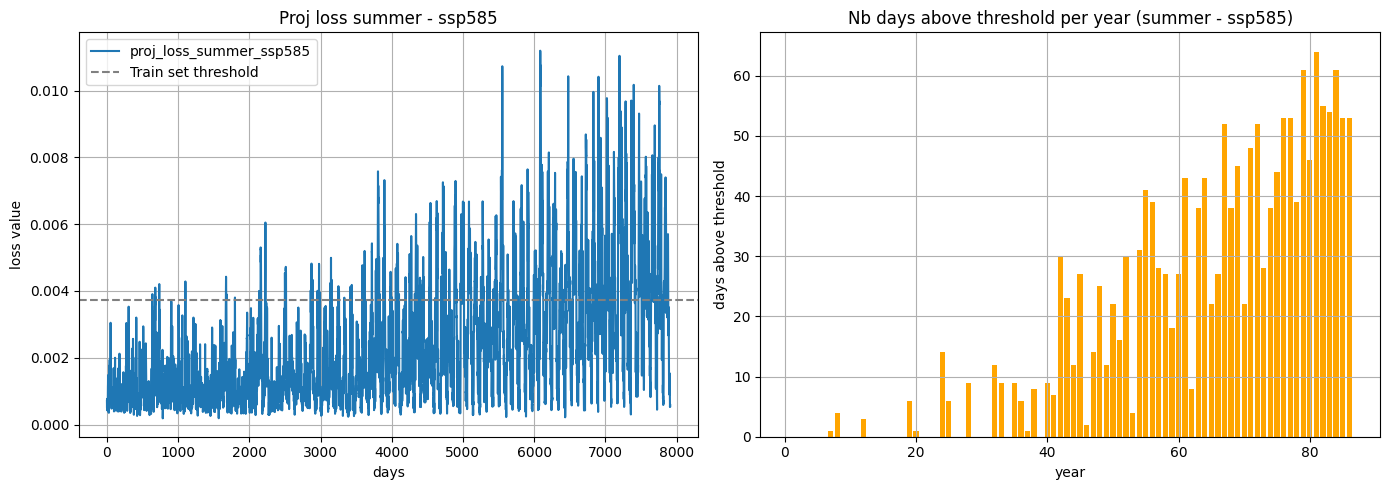

Season summer - Scenario ssp245: 1124 days above threshold 0.0037


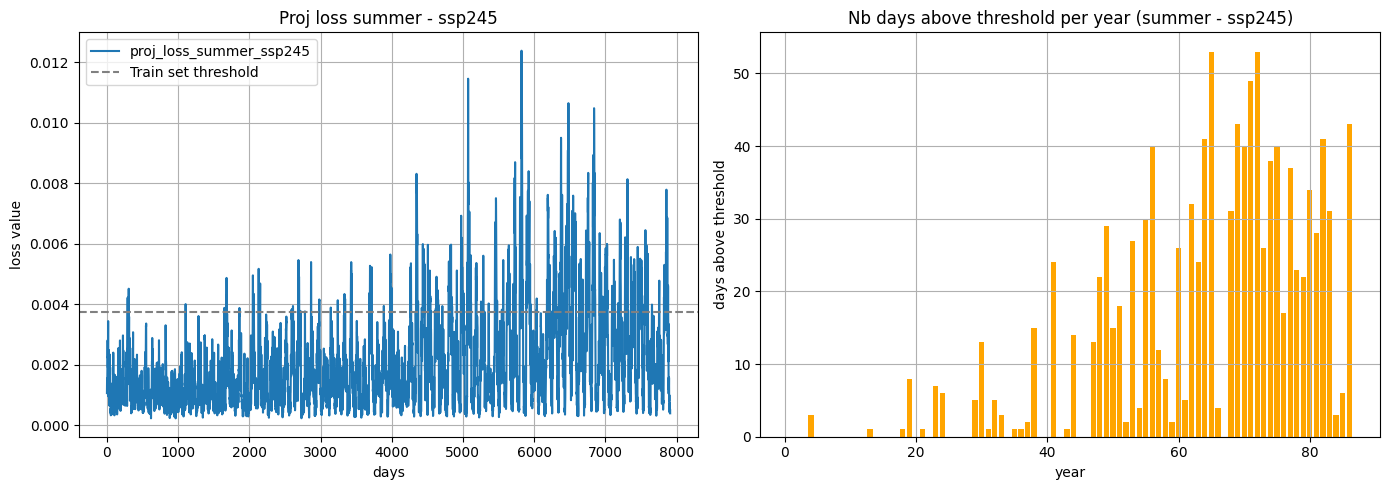

Season autumn - Scenario ssp585: 827 days above threshold 0.0048


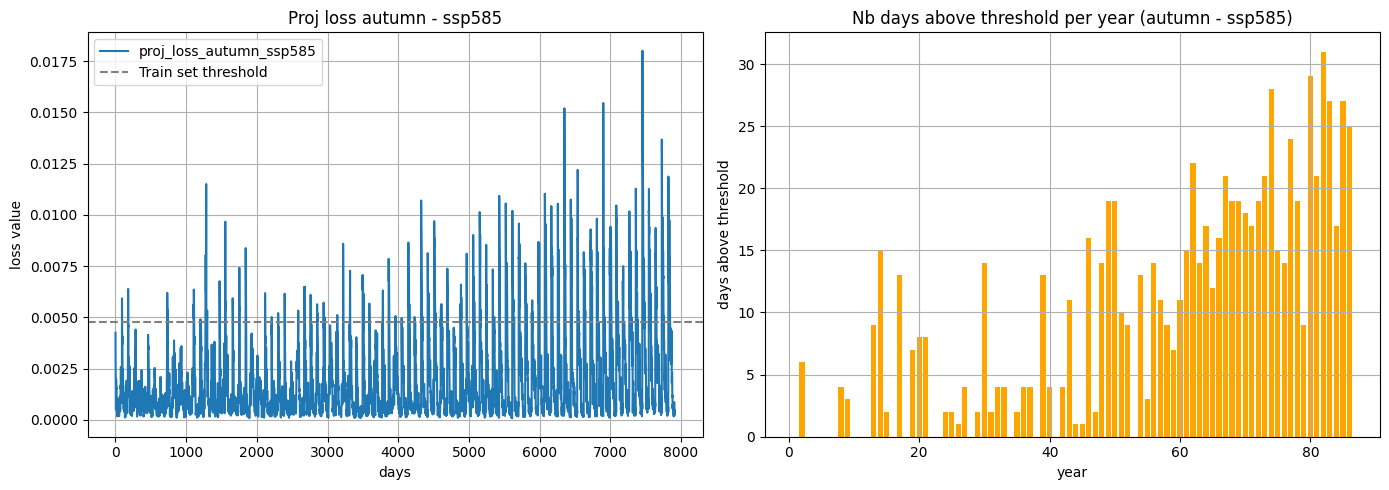

Season autumn - Scenario ssp245: 610 days above threshold 0.0048


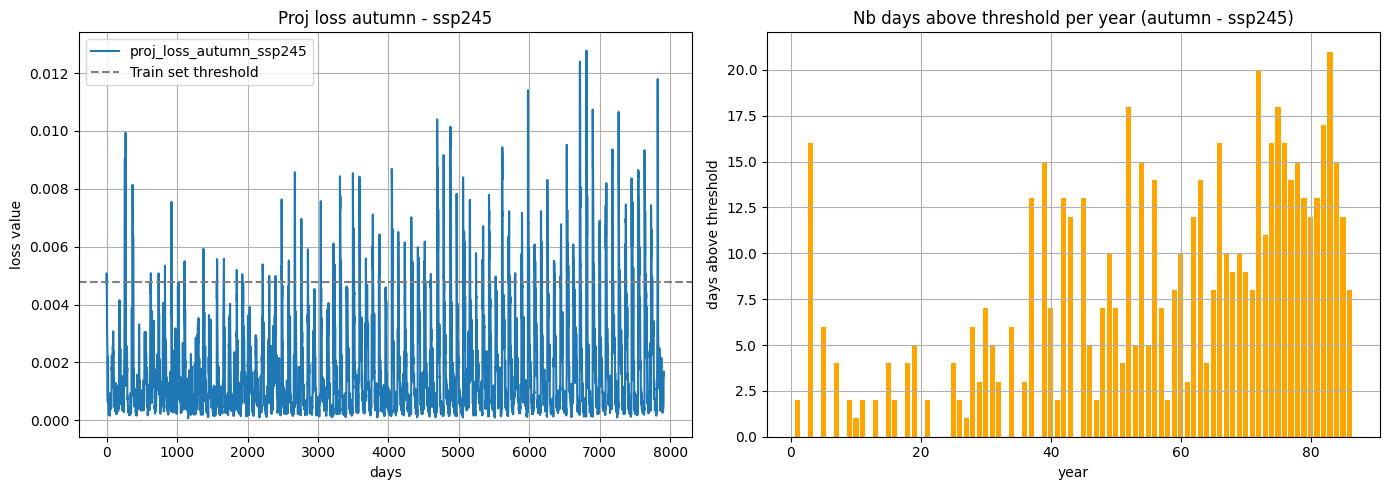

In [ ]:
def display_proj_loss(percentile=99):
    for season in seasons:
        threshold = globals()[f"train_loss_{season}"]["0"].quantile(percentile / 100)
        season_size = season_sizes.get(season, 365)

        for scenario in scenarios:
            proj_loss = globals()[f"proj_loss_{season}_{scenario}"]
            if "Unnamed: 0" in proj_loss.columns:
                proj_loss = proj_loss.drop(columns=["Unnamed: 0"])

            # Plot 1 : courbe normale
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 ligne, 2 colonnes

            axes[0].plot(proj_loss, label=f"proj_loss_{season}_ssp{scenario}")
            axes[0].axhline(y=threshold, color="grey", linestyle="--", label="Train set threshold")
            axes[0].set_title(f"Proj loss {season} - ssp{scenario}")
            axes[0].set_xlabel("days")
            axes[0].set_ylabel("loss value")
            axes[0].set_ylim(0, 0.02)
            axes[0].legend()
            axes[0].grid(True)

            # Calcul du nombre de jours dépassant le seuil
            proj_loss_values = proj_loss.values.flatten()
            window_size = 30  # par exemple : analyser les anomalies tous les 30 jours
            anomaly_windows = detect_anomalies_on_window(proj_loss_values, threshold, window_size)

            # Optionnel : afficher les 5 premières fenêtres ayant le plus d'anomalies
            top_windows = sorted(anomaly_windows, key=lambda x: x[2], reverse=True)[:5]
            print(f"\nTop {len(top_windows)} windows with most anomalies (over {window_size} days):")
            for start, end, count in top_windows:
                print(f"From day {start} to {end}: {count} anomalies")

            num_days_above_threshold = (proj_loss_values > threshold).sum()
            print(f"{season} - Scenario ssp{scenario}: {num_days_above_threshold} days above threshold {threshold:.4f}")

            # Plot 2 : barres annuelles du nombre de jours de dépassement
            num_years = len(proj_loss_values) // season_size
            years = list(range(1, num_years + 1))
            counts_per_year = []

            for i in range(num_years):
                start = i * season_size
                end = start + season_size
                year_data = proj_loss_values[start:end]
                count_above = (year_data > threshold).sum()
                counts_per_year.append(count_above)

            axes[1].bar(years, counts_per_year, color="orange")
            axes[1].set_title(f"Nb days above threshold per year ({season} - ssp{scenario})")
            axes[1].set_xlabel("year")
            axes[1].set_ylabel("days above threshold")
            axes[1].grid(True)

            plt.tight_layout()
            plt.savefig(f"./figs/threshold_exceedance_{season}_{scenario}.png")  # ou .jpg, .pdf, etc.
            plt.show()


display_proj_loss(99)

In [10]:
def display_loss(scenario, day_range=None, year_range=None, aggregation="none"):
    proj_loss_combined = []
    num_blocks = len(globals()[f"proj_loss_winter_{scenario}"])
    num_years = num_blocks // season_sizes["winter"]  # Nombre d'années simulées

    for year_idx in range(num_years):
        for season in seasons:
            loss_df = globals()[f"proj_loss_{season}_{scenario}"]
            season_len = season_sizes[season]
            start = year_idx * season_len
            end = start + season_len
            season_chunk = loss_df.iloc[start:end, 1].values  # Colonne des valeurs de loss
            proj_loss_combined.extend(season_chunk)

    loss_series = pd.Series(proj_loss_combined)

    if day_range is not None:
        start, end = day_range
        loss_series = loss_series.iloc[start:end]
        title = f"ssp{scenario} - jours {start} à {end}"
    elif year_range is not None:
        start_year_idx, end_year_idx = year_range
        start_day = start_year_idx * total_days_per_year
        end_day = end_year_idx * total_days_per_year
        loss_series = loss_series.iloc[start_day:end_day]
        title = f"ssp{scenario} - années {start_year_idx} à {end_year_idx}"
    else:
        title = f"ssp{scenario}"

    if aggregation == "month":
        grouped = loss_series.groupby(loss_series.index // 30).mean()
    elif aggregation == "season":
        grouped = []
        idx = 0
        while idx < len(loss_series):
            for season in seasons:
                season_len = season_sizes[season]
                chunk = loss_series.iloc[idx : idx + season_len]
                if len(chunk) < season_len:
                    break
                grouped.append(chunk.mean())
                idx += season_len
        grouped = pd.Series(grouped)
    elif aggregation == "year":
        grouped = loss_series.groupby(loss_series.index // total_days_per_year).mean()
    else:
        grouped = loss_series

    start_year = 2015
    if aggregation == "day":
        unit_per_year = total_days_per_year
    elif aggregation == "month":
        unit_per_year = 12  # mois par année
    elif aggregation == "season":
        unit_per_year = len(seasons)  # saisons par année
    elif aggregation == "year":
        unit_per_year = 1  # agrégé par année
    else:
        raise ValueError(f"Aggregation inconnue: {aggregation}")

    tick_interval = unit_per_year * 5  # tous les 5 ans
    total_points = len(grouped)
    xticks_pos = list(range(0, total_points, tick_interval))
    xticks_labels = [f"Year {start_year + i * 5}" for i in range(len(xticks_pos))]

    plt.plot(grouped.reset_index(drop=True))
    plt.xticks(xticks_pos, xticks_labels, rotation=45)
    plt.title(f"Projection loss - {title} (per {aggregation})")
    plt.ylabel("Loss value")
    plt.grid(True)
    plt.tight_layout()
    return grouped.reset_index(drop=True)

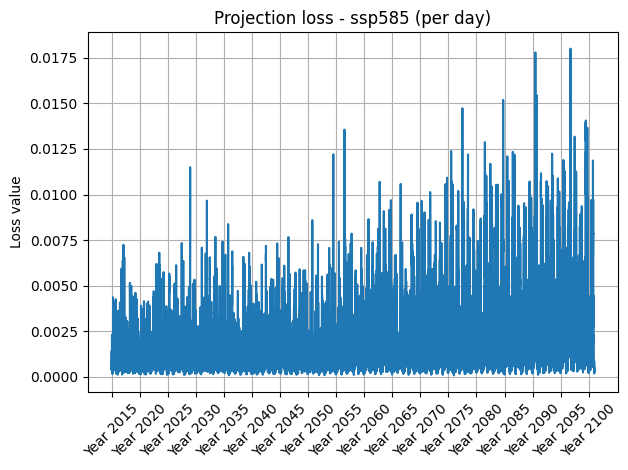

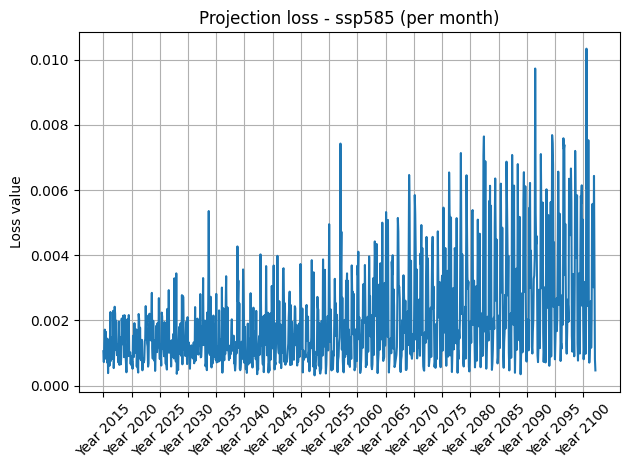

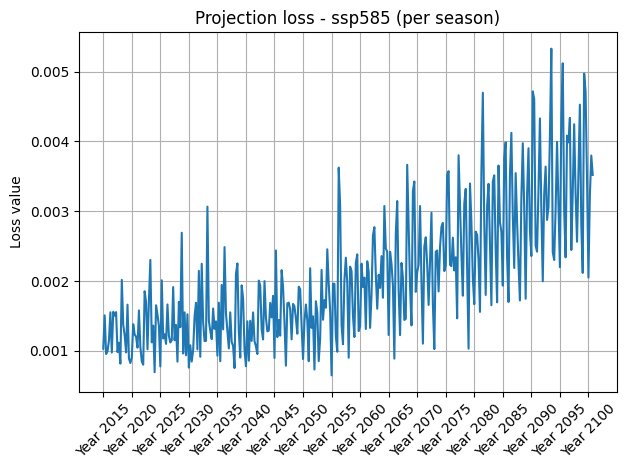

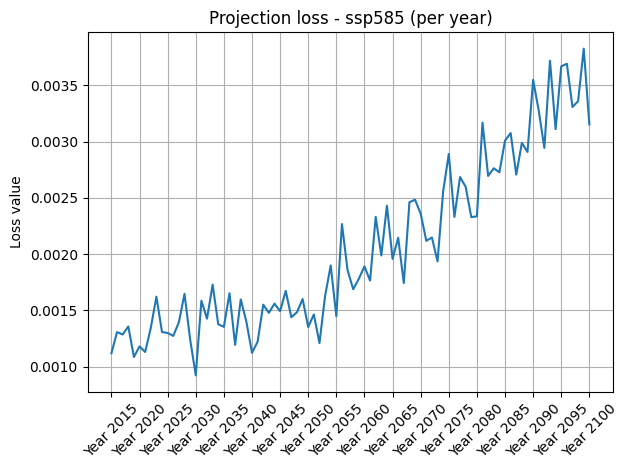

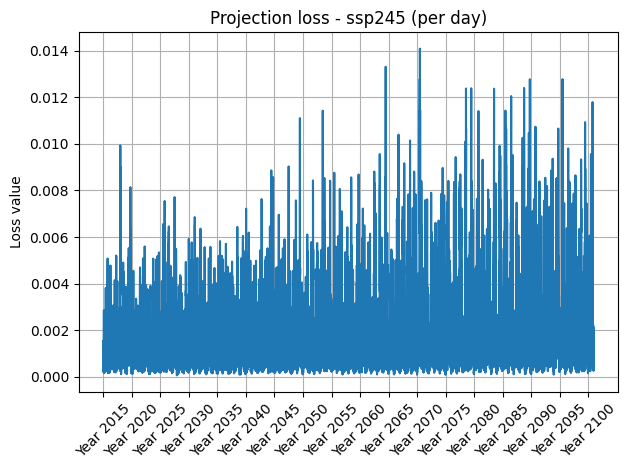

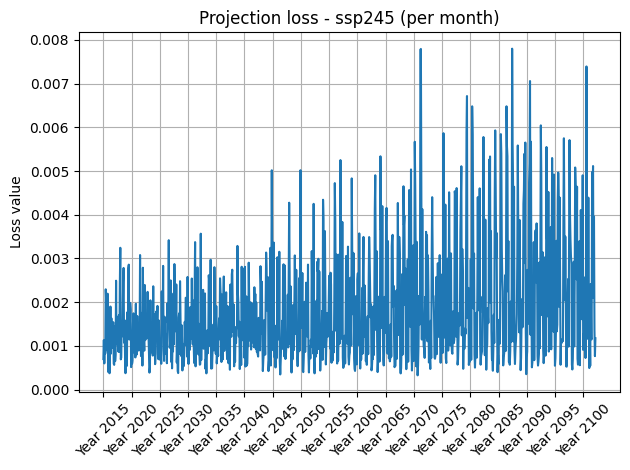

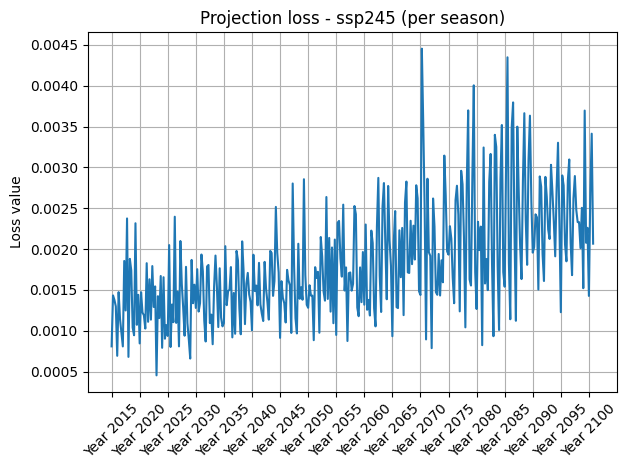

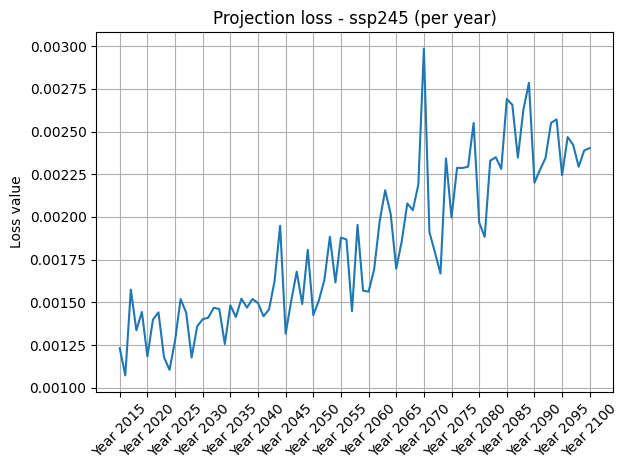

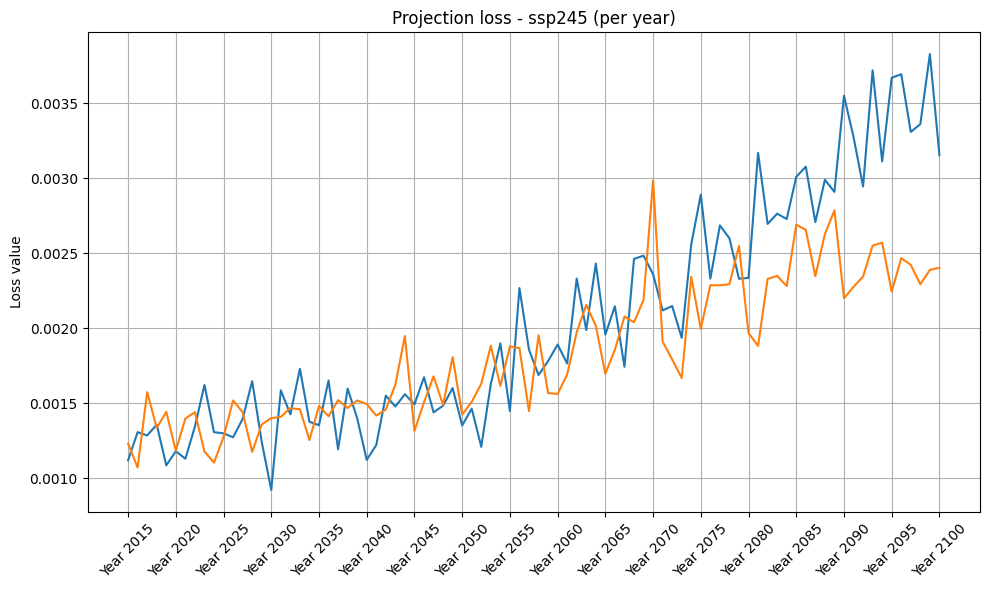

In [ ]:
globals()["loss_per_day"] = []
globals()["loss_per_month"] = []
globals()["loss_per_season"] = []
globals()["loss_per_year"] = []

for scenario in scenarios:
    globals()[f"loss_{scenario}_day"] = display_loss(scenario, aggregation="day")
    plt.show()
    globals()[f"loss_{scenario}_month"] = display_loss(scenario, aggregation="month")
    plt.show()
    globals()[f"loss_{scenario}_season"] = display_loss(scenario, aggregation="season")
    plt.show()
    globals()[f"loss_{scenario}_year"] = display_loss(scenario, aggregation="year")
    plt.show()

    globals()["loss_per_day"].append(globals()[f"loss_{scenario}_day"])
    globals()["loss_per_month"].append(globals()[f"loss_{scenario}_month"])
    globals()["loss_per_season"].append(globals()[f"loss_{scenario}_season"])
    globals()["loss_per_year"].append(globals()[f"loss_{scenario}_year"])

plt.figure(figsize=(10, 6))
for scenario in scenarios:
    globals()[f"loss_{scenario}_year"] = display_loss(scenario, aggregation="year")
plt.show()

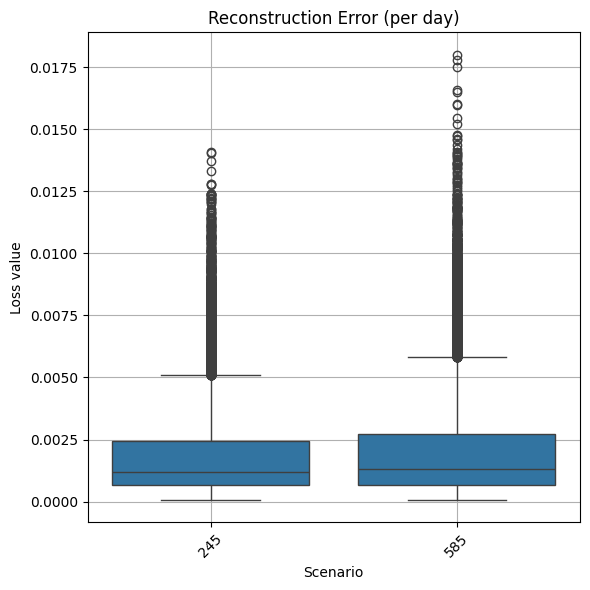

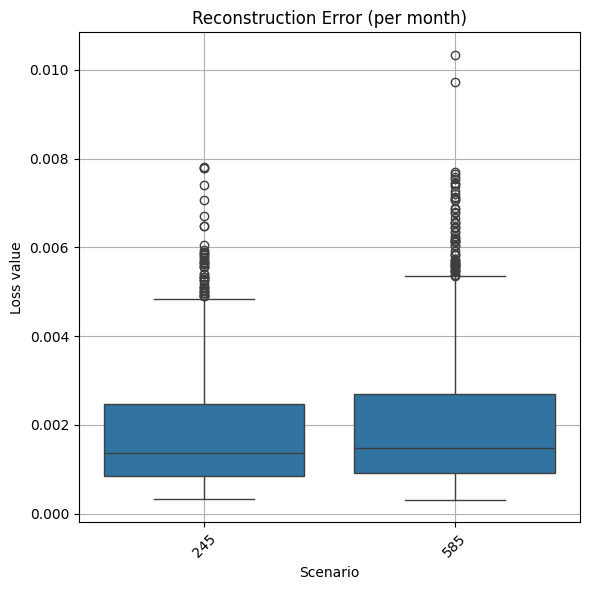

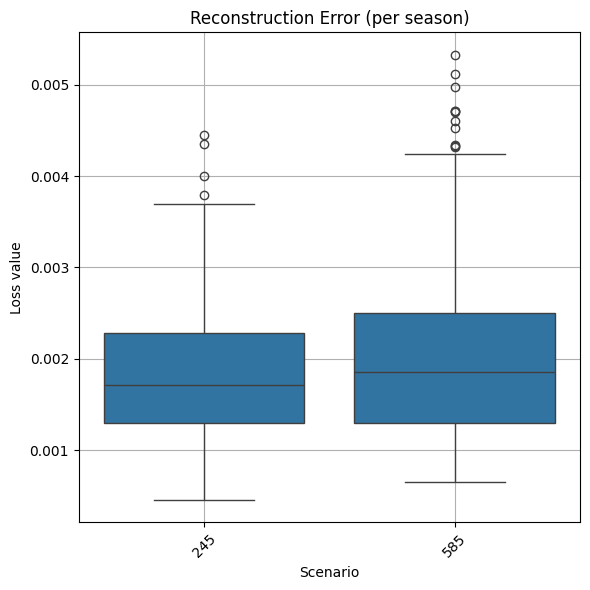

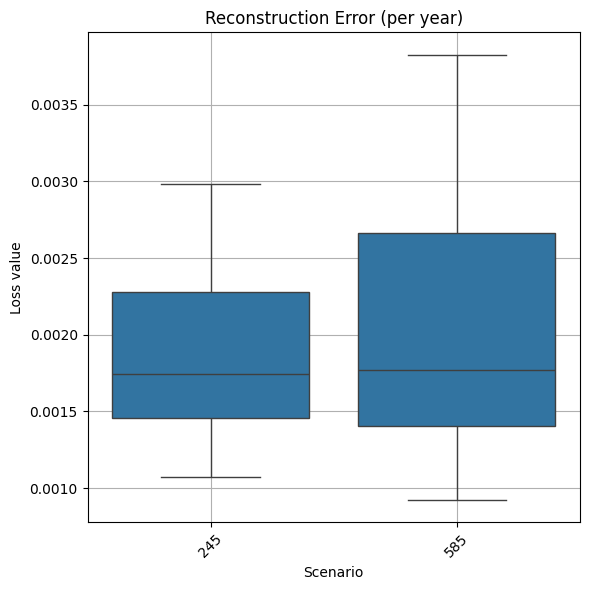

In [12]:
aggregation_type = ["day", "month", "season", "year"]

for agg in aggregation_type:
    data = globals()[f"loss_per_{agg}"]  # liste de listes
    data_long = []

    for i, scenario in enumerate(scenarios):
        scenario_losses = data[i]
        for value in scenario_losses:
            data_long.append({"Scenario": scenario, "Loss value": value})

    df_long = pd.DataFrame(data_long)

    plt.figure(figsize=(6, 6))
    sns.boxplot(x="Scenario", y="Loss value", data=df_long)
    plt.xticks(rotation=45)
    plt.title(f"Reconstruction Error (per {agg})")
    plt.xlabel("Scenario")
    plt.ylabel("Loss value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()